## The implementation of the article "Learning Classifiers from Only Positive and Unlabeled Data" 

Made by Nurlanov Zhakshylyk, 2020

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model as lm
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt

In [2]:
np.random.seed(47)

In [3]:
pos_size = 1000
neg_size = 2000

validation_percent = 20
test_percent = 30
pos_val_size = pos_size * validation_percent // 100
neg_val_size = neg_size * validation_percent // 100
pos_test_size = pos_size * test_percent // 100
neg_test_size = neg_size * test_percent // 100

labeled_percent = 20

## Generate synthetic data

### Add extra features to allow the decision boundary to be nonlinear. 
So, feature vector is $$ [x_1, x_2, x_1 x_2, x_1^2, x_2^2] $$
The feature $ x_1 x_2 $ was especially added to eliminate the restriction (which is in the article) allowing ellipses that are only parallel to the axis. 

In [4]:
def generate_add_features(X):
#     return np.hstack([X, (X[:, 0]**2).reshape(-1, 1), (X[:, 1]**2).reshape(-1, 1)])
    return np.hstack([X, (X[:, 0]*X[:, 1]).reshape(-1, 1), (X[:, 0]**2).reshape(-1, 1), (X[:, 1]**2).reshape(-1, 1)])

In [5]:
positive_mean = np.array([1.0, 5.0])
positive_cov  = np.array([[  1.0, 0.6], 
                          [  0.6, 2.0]])

X_pos = np.random.multivariate_normal(positive_mean, positive_cov, pos_size)
X_pos = generate_add_features(X_pos)

In [6]:
negative_mean = np.array([-1.0, -2.0])
negative_cov  = np.array([[ 3.0, 0.8],
                          [ 0.8, 4.0]])

X_neg = np.random.multivariate_normal(negative_mean, negative_cov, neg_size)
X_neg = generate_add_features(X_neg)

[Text(0, 0.5, '$X_2$'), Text(0.5, 0, '$X_1$')]

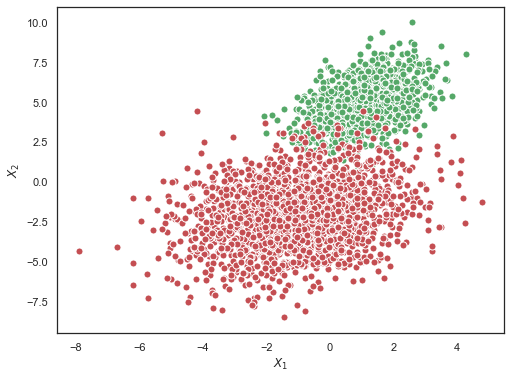

In [7]:
f, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X_pos[:,0], X_pos[:, 1], color='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X_neg[:,0], X_neg[:, 1], color='r', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")

## Split data to train/test/val

In [8]:
np.random.shuffle(X_pos)
np.random.shuffle(X_neg)

In [9]:
X_test_pos, X_val_pos = X_pos[: pos_test_size], X_pos[pos_test_size: pos_test_size+pos_val_size]
X_train_pos = X_pos[pos_test_size+pos_val_size: ]

X_test_neg, X_val_neg = X_neg[: neg_test_size], X_neg[neg_test_size: neg_test_size+neg_val_size]
X_train_neg = X_neg[neg_test_size+neg_val_size: ]

In [10]:
print(X_train_pos.shape, X_train_neg.shape)

(500, 5) (1000, 5)


## Split training data to labeled and unlabeled

In [11]:
## randomness of sampling
np.random.shuffle(X_train_pos)
np.random.shuffle(X_train_neg)

In [12]:
labeled_size = X_train_pos.shape[0] * labeled_percent // 100
X_labeled = X_train_pos[: labeled_size]
X_unlabeled = np.vstack([X_train_pos[labeled_size :], X_train_neg])

In [13]:
X_lab_size =  X_labeled.shape[0]
X_unlab_size = X_unlabeled.shape[0]
print(X_labeled.shape, X_unlabeled.shape)

(100, 5) (1400, 5)


_______________
# Method 1
## Lerning traditional classifier from nontraditional input 

## Approximate $g(x)$ using Logistic Regression as a parametric model:
$$ g_{\theta}(x) \approx \mathbb{P}(s=1|x) $$


In [14]:
y_lab = np.ones((X_lab_size, 1))
y_unlab = np.zeros((X_unlab_size, 1))
y = np.vstack([y_lab, y_unlab])
X = np.vstack([X_labeled, X_unlabeled])
X_y = np.hstack([X, y])

In [15]:
np.random.shuffle(X_y)

In [16]:
g_x = lm.LogisticRegression(solver='lbfgs')
g_x.fit(X_y[:, :-1], X_y[:, -1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Approximate sampling constant $c$ on validation set $V$
$$c = \mathbb{P}(s=1|y=1)$$ by

$$e_1 = \frac{1}{n} \sum_{x \in P}g(x) \approx c,$$ where $P$ is subset of positive elements in $V$, and $n = |P|$

In [17]:
print(X_val_pos.shape)

(200, 5)


In [18]:
val_size_to_approx = 30
P = X_val_pos[:val_size_to_approx]

In [19]:
sumP = sum(g_x.predict_proba(P)[:, 1])

In [20]:
e_1 = sumP / val_size_to_approx

In [21]:
print(f"real c = {labeled_percent}, estimated e_1 = {e_1*100:.2f} on {val_size_to_approx} objects")

real c = 20, estimated e_1 = 19.14 on 30 objects


$$ e_2 = \frac{\sum_{x \in P}g(x)}{\sum_{x \in V}g(x)}  $$

In [22]:
rest_pos_size = 30 * 80 // 20
restP = X_val_pos[val_size_to_approx: val_size_to_approx+rest_pos_size]
N = X_val_neg[:(val_size_to_approx+rest_pos_size)*2]

In [23]:
e_2 =  sumP / (sumP + sum(g_x.predict_proba(N)[:, 1]) + sum(g_x.predict_proba(restP)[:, 1]))

In [24]:
print(f"real c = {labeled_percent}, estimated e_2 = {e_2*100:.2f} on {3*(val_size_to_approx+rest_pos_size)} objects")

real c = 20, estimated e_2 = 18.83 on 450 objects


$$ e_3 = \max_{x \in V}g(x) $$

In [25]:
e_3 = max(np.max(g_x.predict_proba(X_val_pos[: val_size_to_approx+rest_pos_size])[:, 1]), np.max(g_x.predict_proba(N)[:, 1]))

In [26]:
print(f"real c = {labeled_percent}, estimated e_3 = {e_3*100:.2f} on {3*(val_size_to_approx+rest_pos_size)} objects")

real c = 20, estimated e_3 = 25.48 on 450 objects


### Conclusion:
The first and second approximations of constant $c$ are acceptable, third one is not stable.

## Apply using formula:
$$ \mathbb{P}(y=1|x) = f(x) = g(x)/c $$

In [27]:
prob_pos = g_x.predict_proba(X_test_pos)[:, 1]/e_1
prob_neg = g_x.predict_proba(X_test_neg)[:, 1]/e_1

In [28]:
print("Accuracy = ", (np.sum(prob_pos >= 0.5) + np.sum(prob_neg < 0.5))/(prob_pos.shape[0] + prob_neg.shape[0]))

Accuracy =  0.9711111111111111


## Visualize decision boundary

In [29]:
xx, yy = np.mgrid[-6:5:.01, -10:11:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = generate_add_features(grid)
probs = g_x.predict_proba(grid)[:, 1].reshape(xx.shape) / e_1

[Text(0, 0.5, '$X_2$'), Text(0.5, 0, '$X_1$')]

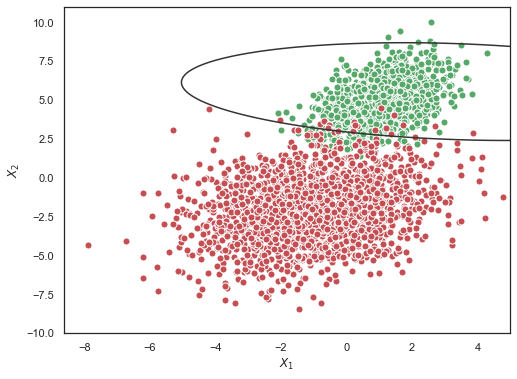

In [30]:
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X_pos[:,0], X_pos[:, 1], color='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X_neg[:,0], X_neg[:, 1], color='r', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")

## Conclusion:
We got acceptable results using only positive labeled and unlabeled data. 

It is noteworthy that we labeled only 20% of all positive data, and used only 30 positive examples to estimate this percentage.

______________
# Method 2: 
## Weighting unlabeled data using $g(x)$ from previous method

## Calculate weights of unlabeled data using formula:
$$ w(x) = \mathbb{P}(y=1|x, s=0) = \frac{1-c}{c} \cdot \frac{\mathbb{P}(s=1|x)}{1 - \mathbb{P}(s=1|x)} = 
\frac{1-c}{c} \cdot \frac{g(x)}{1-g(x)}
$$


In [31]:
g_unlab = g_x.predict_proba(X_unlabeled)[:, 1]
weights_unlab = (1-e_1)/(e_1)*(g_unlab)/(1-g_unlab)

## Train traditional classifier with weighted unlabeled data. 
Make one copy of unlabeled data positive, i.e. $y=1$, with weights $w(x)$,

make second copy of unlabeled data negative, i.e. $y=0$, with weights $1-w(x)$.

In [32]:
X_lab_size =  X_labeled.shape[0]
X_unlab_size = X_unlabeled.shape[0]

# array of answers
y_lab = np.ones((X_lab_size, 1))
y_unlab_pos = np.ones((X_unlab_size, 1))
y_unlab_neg = np.zeros((X_unlab_size, 1))
y = np.vstack([y_lab, y_unlab_pos, y_unlab_neg])

# array of weights
w_lab = np.ones((X_lab_size, 1))
w_unlab_pos = weights_unlab.reshape(-1, 1)
w_unlab_neg = 1 - weights_unlab.reshape(-1, 1)
w = np.vstack([w_lab, w_unlab_pos, w_unlab_neg])

# array of data and all together
X = np.vstack([X_labeled, X_unlabeled, X_unlabeled])
X_y = np.hstack([X, y, w])

In [33]:
np.random.shuffle(X_y)

In [34]:
f_x_weighted = lm.LogisticRegression(solver='lbfgs')
f_x_weighted.fit(X_y[:, :-2], X_y[:, -2], sample_weight=X_y[:, -1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Apply directly to test set

In [35]:
all_tp = np.sum(f_x_weighted.predict(X_test_pos)) + np.sum(f_x_weighted.predict(X_test_neg) == 0)
print("Test accuracy = ", all_tp / (X_test_pos.shape[0] + X_test_neg.shape[0]))

Test accuracy =  0.9722222222222222


## Visualize decision boundary

In [36]:
xx, yy = np.mgrid[-6:5:.01, -10:11:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = generate_add_features(grid)
probs = f_x_weighted.predict_proba(grid)[:, 1].reshape(xx.shape)

[Text(0, 0.5, '$X_2$'), Text(0.5, 0, '$X_1$')]

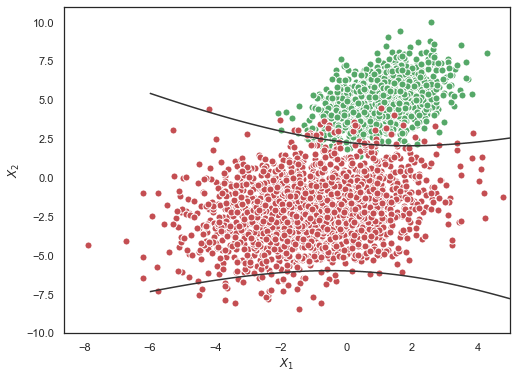

In [37]:
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X_pos[:,0], X_pos[:, 1], color='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X_neg[:,0], X_neg[:, 1], color='r', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")

## Conclusion
We again obtained acceptable results using only positive (20%) labeled and unlabeled data.

Interestingly, method #2 pays more attention to negative data trying to separate them from positive examples, and method #1, on the contrary, tried to separate positive data from negative ones.

It is likely that for the one-class classification task the first method will be preferable.